In [44]:
using Plots
using LaTeXStrings
using LinearAlgebra
using FFTW
using BenchmarkTools
using Distributions
# using Unwrap
# using JuMP
# using Ipopt
# using Unwrap
using Pkg
using Random
# Pkg.add("PyCall") 

In [45]:
function fftnshift(A::AbstractArray)
    B = copy(A)
    return fftshift(fft(fftshift(B)))
end
function ifftnshift(A::AbstractArray)
    B = copy(A)
    return fftshift(ifft(ifftshift(B)))
end

ifftnshift (generic function with 1 method)

In [46]:
function fft_1dcustom!(x_re, x_im)
    N = length(x_re)
    @assert N == length(x_im) "re/im must match length"
    @assert ispow2(N) "Length must be a power of two"

    # Bit‑reversal on both real & imag
    bits = Int(floor(log2(N)))
    for i in 0:N-1
        j = bitreverse(i) >>> (sizeof(Int)*8 - bits)
        if j > i
            x_re[i+1], x_re[j+1] = x_re[j+1], x_re[i+1]
            x_im[i+1], x_im[j+1] = x_im[j+1], x_im[i+1]
        end
    end

    # Cooley‑Tuk stages
    m = 1
    while m < N
        half = m
        m *= 2
        θ = -2π / m
        @inbounds for j in 0:half-1
            c = cos(θ*j)     # real constant :contentReference[oaicite:8]{index=8}
            s = sin(θ*j)
            for k in j:m:N-1
                u = k + 1
                v = k + half + 1
                u_re, u_im = x_re[u], x_im[u]
                v_re, v_im = x_re[v], x_im[v]

                # complex multiply (v * cis(θ*j)) in real form
                t_re =  c*v_re - s*v_im
                t_im =  s*v_re + c*v_im

                # butterfly
                x_re[u] = u_re + t_re
                x_im[u] = u_im + t_im
                x_re[v] = u_re - t_re
                x_im[v] = u_im - t_im
            end
        end
    end

    return nothing
end
function fft_2dcustom(A)
    Ny, Nx = size(A)
    @assert ispow2(Ny) && ispow2(Nx) "Both dimensions must be powers of 2"
    B = copy(A)

    # 1) FFT down each column
    @inbounds @simd for x in 1:Nx
        B[:, x] = fft_1dcustom!(view(B, :, x, 1), view(B, :, x, 2))
    end

    # 2) FFT across each row of the intermediate result
    @inbounds @simd for y in 1:Ny
        B[y, :] = fft_1dcustom!(view(B, y, :, 1), view(B, y, :, 2))
    end

    return B
end

fft_2dcustom (generic function with 1 method)

In [47]:
function Find_Crossing(func, y_point, x)
    N = length(func)
    f = func .- y_point
    x_intercepts = []

    for i in 1:N-1
        if f[i]*f[i+1] < 0
            # Linear interpolation to find the crossing point
            dfdx = (f[i+1] - f[i]) / (x[i+1] - x[i])
            x_intercept = x[i] - f[i]/dfdx
            x_intercepts = push!(x_intercepts, x_intercept)
        end
        
    end
    return x_intercepts
end
function Find_Spacing(x_intercepts)
    if length(x_intercepts) == 0
        return Inf
    end


    if mod(length(x_intercepts),2) == 1
        x_intercepts = x_intercepts[1:end-1]
    end
    centers = @. (x_intercepts[1:2:end] + x_intercepts[2:2:end])/2
    
    spacing = centers[2:end] .- centers[1:end-1]
    spacing = sort!(spacing)
    return spacing[length(spacing)÷2]
end

Find_Spacing (generic function with 1 method)

In [ ]:
function Noisy_Image(A::AbstractMatrix{<:Number}, N_electrons::Real ,
    background_noise::Real, kspace=false) 


    image = copy(A)
    if kspace
        # image is assumed to be in reciprocal space and normally ordered
        image = ifftnshift(image)
    end
    image = abs.(image) # image is assumed to be in real-space and real


    image_normalized = N_electrons .* image./sum(image)
    background_noise = rand(Poisson(background_noise), size(image))
    image_poisson =  rand.(Poisson.(image_normalized))
    image_noisy = image_poisson .+ background_noise

    if kspace
        image_noisy = fftnshift(image_noisy)
    return image_noisy
    end

    return image_noisy
end

function Diff_Image(image, c=0.01)
    return @. log1p(c*abs(image))
end
function Autocorrelation(image)
    # the image is assumed to be in real space
    
    image_fft = fftnshift(image)
    image_auto = ifftnshift(image_fft .* conj.(image_fft))
    if eltype(image) <: Real 
        return real.(image_auto)
    end
    return image_auto
end
function Autocorrelation_Normalized(image)
    # the image is assumed to be in real space
    Ny, Nx = size(image)
    image_auto = Autocorrelation(image)
    image_auto = image_auto./(Ny*Nx)
    image_auto = image_auto .- sum(image_auto)/(Ny*Nx)
    image_auto = image_auto ./ maximum(abs.(image_auto))
    return image_auto
end

Autocorrelation_Normalized (generic function with 1 method)

In [49]:
function Wavelength(E)
    hc = 12.398 #keV*Angstrom
    # h = 6.582119e-16 #eV*sec
    # mc2 = 511 #keV
    E₀ = 511.0 #keV
    return hc/sqrt(abs(E*(2*E₀ + E)))
end

function Focus(E, Cs, nᵢ=1)
    return sqrt((2*nᵢ-0.5)*Cs*Wavelength(E))
end
kmax(E, Cs) = (6/((Cs*Wavelength(E)^3)))^(1/4)

kmax (generic function with 1 method)

In [50]:
E = 300.0 #keV
Cs = 1 #mm
Cs = Cs * 1e7 #convert to Angstroms
λ_const = Wavelength(E)

N = 2^6
physical_scale = 1
camera_scale = 2

upper = (N-1)/2 + 0.1
lower = (-N+1)/2
kx = lower:1:upper
ky = lower:1:upper

k = @. sqrt(kx'^2 + ky^2)
disk = k.<=N/2
disk = Float64.(disk)

kx = kx./maximum(kx).*kmax(E, Cs)
ky = ky./maximum(ky).*kmax(E, Cs)
k = @. sqrt(kx'^2 + ky^2)


Δk = kx[2] - kx[1]
L = 1/Δk
ΔL = L/N

x = LinRange(-L/2, L/2, N)
y = LinRange(-L/2, L/2, N)


λ(E) = Wavelength(E)
Δf(E, Cs) = Focus(E, Cs)
χ(k) =@. π*λ(E)*k^2*(0.5*Cs*λ(E)^2*k^2 - Δf(E, Cs))
H = @. exp(-1im*χ(k)*disk)*disk
f(x, y, xc, yc, σ₁, σ₂) = @. (1/((2*pi)*sqrt(σ₁*σ₂)))*exp(-(x - xc)^2/(2σ₁^2) -(y - yc)^2/(2σ₂^2) )
heatmap(kx, ky, angle.(H), title="angle of the tansfer function H",  
        xlabel=L"k_x\, Å^{-1}", ylabel=L"k_y\, Å^{-1}", aspect_ratio=1)
xlims!(kx[1], kx[end])
ylims!(ky[1], ky[end]);

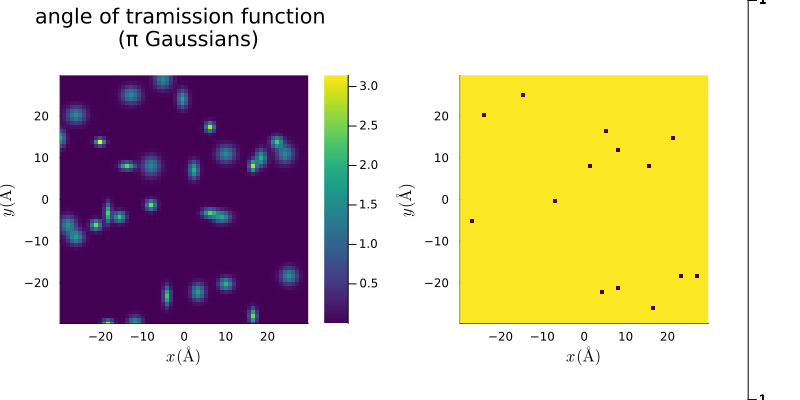

GKS: Rectangle definition is invalid in routine CELLARRAY
GKS: Rectangle definition is invalid in routine CELLARRAY
GKS: Rectangle definition is invalid in routine CELLARRAY


In [51]:
S = 5
σ₊, σ₋ = 7, 7
phase_real = zeros(N, N)
phase_complex = zeros(N, N)
# indices = round.(Int, LinRange(1, N, S))

# for i in indices, j in indices
#     xc = x[i]
#     yc = y[j]
#     phase_real += f(x',y, xc, yc, σ₊, σ₋)
#     phase_complex += f(x',y, xc, yc, σ₊, σ₋) 
# end
xc, yc = 0.0, 0.0
σx, σy = 1, 7
θ_rot = deg2rad(0)
rotatedx = @. cos(θ_rot)*x' + sin(θ_rot)*y
rotatedy = @. -sin(θ_rot)*x' + cos(θ_rot)*y
Random.seed!(1)
phase_real = zeros(N, N)
phase_complex = zeros(N, N)
for i in 1:30
    xc = rand(x)
    yc = rand(y)
    σx, σy = rand(Uniform(0.5, 1.5)), rand(Uniform(0.5, 1.5))
    phase_real += f(rotatedx,rotatedy, xc, yc, σx, σy)
    phase_complex += f(rotatedx,rotatedy, xc, yc, σx, σy) 
end
# phase_real = f(rotatedx,rotatedy, xc, yc, σx, σy) + f(rotatedx,rotatedy, xc+3, yc, σx, σy)
# phase_complex = f(rotatedx,rotatedy, xc, yc, σx, σy) + f(rotatedx,rotatedy, xc+3, yc, σx, σy)


phase_real = phase_real./maximum(phase_real) *π
phase_complex = phase_complex./maximum(phase_complex) * 0.1
phase = phase_real #+ 1im*phase_complex

transmission = @. cis(phase);


fig1 = heatmap(x,y,abs.(phase), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)
xlabel!(L"x\, (Å)")
ylabel!(L"y\, (Å)")
xlims!(-L/2, L/2)
ylims!(-L/2, L/2)
title!("angle of tramission function \n (π Gaussians)")
# vline!([spacing_x], color=:black, lw=2)
# hline!([spacing_y], color=:black, lw=2)

fig2 = heatmap(x,y,abs.(transmission), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)
xlabel!(L"x\, (Å)")
ylabel!(L"y\, (Å)")
xlims!(-L/2, L/2)
ylims!(-L/2, L/2)

plot(fig1, fig2, layout=(1,2), size=(800, 400), legend=false)

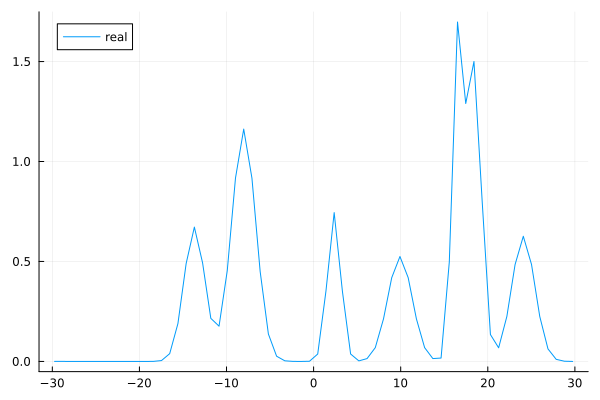

In [52]:
plot(x,phase_real[N÷2+10,:], label="real")

In [53]:
Reference_Wave(θ, ϕ) = @. exp(1im * 2*π/kmax(E,Cs) * (sin(θ)*cos(ϕ)*x' + sin(θ)*sin(ϕ)*y))
wave_ref = ifftnshift(fftnshift(Reference_Wave(0.2, 0)).*H)
transmission = @. exp(1im * phase);
heatmap(x, y, angle.(wave_ref), aspect_ratio=1, c=:viridis, colorbar=true, axis=true);


In [54]:
probe = ifftnshift(H)
probe = probe./sqrt(sum(abs2.(probe)))
heatmap(x, y, abs.(probe), aspect_ratio=1, c=:viridis, colorbar=true, axis=true);

In [55]:
raster_shifts = @. cispi(2*(kx' * x' + ky * y))

heatmap(x, y, angle.(raster_shifts), 
    aspect_ratio=1, 
    c=:viridis, 
    colorbar=true, 
    xlabel="x", 
    ylabel="y");

In [56]:
function Rasters_fft(raster_shifts, tf_wave_fft, H)
    Ny, Nx = size(raster_shifts)
    # rasters_fft = Array{ComplexF64}(undef, N, N, N, N)
    common_factor = @. tf_wave_fft * H  # element-wise multiplication of tf_wave_fft and H
    rasters_fft = reshape(raster_shifts, Ny, Nx, 1, 1) .* reshape(common_factor, 1, 1, Ny, Nx)
    return rasters_fft
end

Rasters_fft (generic function with 1 method)

In [57]:
wave_obj_fft = fftnshift(transmission.*probe)
rasters_fft = Rasters_fft(raster_shifts, wave_obj_fft, H);

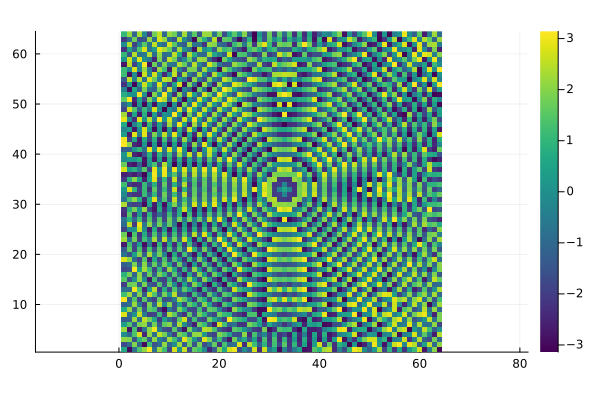

In [58]:
heatmap(angle.(ifftnshift(rasters_fft[1, 1, :, :])), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)

In [182]:

measurement(i,j) = abs2.(wave_ref .+ ifft(rasters_fft[i,j,:,:]))
measurement_noisy(i,j,N_electrons=1e2,B=0.01) = Noisy_Image(measurement(i,j), N_electrons, B)


measurement_fft(i,j) = @. fftnshift(measurement_noisy(i,j))
measurement_autocorr(i,j) = Autocorrelation_Normalized(measurement(i,j))
heatmap(x, y, Diff_Image(measurement_fft(1,1)), aspect_ratio=1, c=:viridis, colorbar=true, axis=true) 
# heatmap(x, y, Diff_Image(measurement_fft(1,1)), aspect_ratio=1, c=:viridis, colorbar=true, axis=true) 
# heatmap(kx, ky, Diff_Image(measurement_fft(30,30)), aspect_ratio=1, c=:viridis, colorbar=true, axis=true); 

In [185]:
measurement_noised = Array{Float64}(undef, N, N, N, N)
for i in 1:N, j in 1:N
    measurement_noised[i,j,:,:] = Noisy_Image(measurement(i,j), 1e2, 0.01)
end
noised_reshaped = reshape(measurement_noised, N*N*N*N);

In [186]:
println(sum(measurement_noised[5,10,:,:]))
sum(rand(Poisson(1), size(measurement_noised[5,10,:,:])))

130.0


4151

In [ ]:
shift = -1
k, l = 25, 3
plot(x,abs.(measurement_fft(k,l)[N÷2-shift,:]), label="FFT of measurement", legend=:topright)
ylims!(0,maximum(abs.(measurement_fft(k,l)))*1)

In [ ]:
plot(x[1:end-1],Diff_Image(diff(abs.(measurement_fft(k,l)[N÷2-shift,:]))))

In [ ]:
plot(x[1:end-2],Diff_Image(diff(diff(abs.(measurement_fft(k,l)[N÷2-shift,:])))));

In [237]:
println(Wavelength(E))

0.019686806700005176


In [106]:
χ_array_alloc = Matrix{Float64}(undef, N, N)
function H_transfer(Cs,k_grid=k,Energy::T=E, bin_disk=disk, 
    λ::T=λ_const,χ::typeof(χ_array_alloc)=χ_array_alloc)::Matrix{Complex{T}} where {T<:AbstractFloat}


    # returns the transfer function H matrix
    @. χ = π*λ*k_grid^2*(0.5*Cs*λ^2*k_grid^2 - sqrt(3/2 * Cs * λ))
    
    return @. cis(-χ*bin_disk)*bin_disk
end
function H_transfer(Cs::T,θ::T,φ::T, λ::T=λ_const)::Complex{T} where {T<:AbstractFloat}


    # returns the transfer function H scalar
    kxy_mag2::T = (sin(θ)/λ)^2  
    χ::T = π*λ*kxy_mag2*(0.5*Cs*λ^2*kxy_mag2 - sqrt(3/2 * Cs * λ))
    
    if kxy_mag2 > kmax(E,Cs)^2
        return zero(Complex{T})
    else
        return cis(-χ)::Complex{T}
    end
end




function wiggle_factor_2ndterm(θ::T,φ::T, x::AbstractVector{T}=x, y::AbstractVector{T}=y,
                     Energy::T=E, λ::T=λ_const)::Matrix{Complex{T}} where {T<:AbstractFloat} 
                     
    return @. cispi(2*sin(θ)/λ * (cos(φ)*x' + sin(φ)*y))
end


function first_term(Cs::T,ϕ::AbstractMatrix{T} , k_grid=k, 
    wiggle_factor::AbstractMatrix{Complex{T}} = raster_shifts)::Matrix{Complex{T}} where {T<:AbstractFloat}

    return cis.(ϕ).*ifftnshift(wiggle_factor.*H_transfer(Cs))
end
# function second_term(Cs::T, θ::T, φ::T) where {T<:AbstractFloat}
#     return H_transfer(Cs, θ, φ).*wiggle_factor_2ndterm(θ, φ)
# end
function second_term(Cs::T, θ::T, φ::T)::Matrix{Complex{T}} where {T<:AbstractFloat}
    return H_transfer(Cs, θ, φ).*wiggle_factor_2ndterm(θ, φ)
    # return h
end

second_term (generic function with 1 method)

In [65]:
using Random
using Turing
using MCMCChains
# using Pigeons
using StatsPlots
using Distributions
using Pkg
# Pkg.add("AdvancedMH")
# Pkg.add("Pigeons")
# using AdvancedMH

In [25]:

Threads.nthreads()

26

In [ ]:
Random.seed!(1)  # For reproducibility
@model function infinite_chain(y, Nx=N, Ny=N)
    # Priors
    # Cs = 1 #mm
    # Cs = Cs * 1e7 #convert to Angstroms
    B ~ Exponential(1)
    Cs ~ truncated(Normal(1e7, 3e6), 0, Inf)
    θ ~ Exponential(20)
    φ ~ Normal(0, 0.1)
    ϕ ~ filldist(truncated(Normal(π/2, π),0,3*π/2), Ny, Nx)


    # Likelihood
    
    y ~ arraydist(Poisson.(vec(
        abs2.(
            reshape(first_term(Cs, ϕ),Ny,Nx,1,1 ) .+ 
            reshape(second_term(Cs, θ, φ), 1, 1, Ny, Nx)) 
            .+ B)))
    
end
n_chains = 3
n_rounds = 5
my_turing_model = TuringLogPotential(infinite_chain(noised_reshaped))
inputs = Inputs(target = my_turing_model,
            n_chains = n_chains,
            n_rounds = n_rounds,
            multithreaded = true,
            record = [traces])

pt = pigeons(inputs)


In [196]:
using AdvancedHMC

In [198]:
Random.seed!(1)  # For reproducibility
@model function infinite_chain(y, Nx=N, Ny=N)
    # Priors
    # Cs = 1 #mm
    # Cs = Cs * 1e7 #convert to Angstroms
    A ~ truncated(Normal(100, 15), 10, 200)
    B ~ Uniform(0,0.1)
    Cs ~ truncated(Normal(1e7, 3e6), 0, Inf)
    θ ~ truncated(Normal(0.1, 1), 0, 1)
    φ ~ Normal(0, 0.1)
    ϕ ~ filldist(Uniform(0,3*π/2), Ny, Nx)


    # Likelihood
    
    y ~ arraydist(Poisson.(vec(
        A.*abs2.(
            reshape(first_term(Cs, ϕ),Ny,Nx,1,1 ) .+ 
            reshape(second_term(Cs, θ, φ), 1, 1, Ny, Nx)) 
            .+ B)))
    
end
# Generate synthetic data
n = 10

# Fit the model
model = infinite_chain(noised_reshaped)
sampler = Turing.SGLD(0.01)
chain = sample(model, sampler, MCMCThreads(), n, 8, progress=true)
# Plot the results
# plot(x,y)

Sampling (8 threads)   0%|                              |  ETA: N/A


CompositeException: Error trying to display an error.

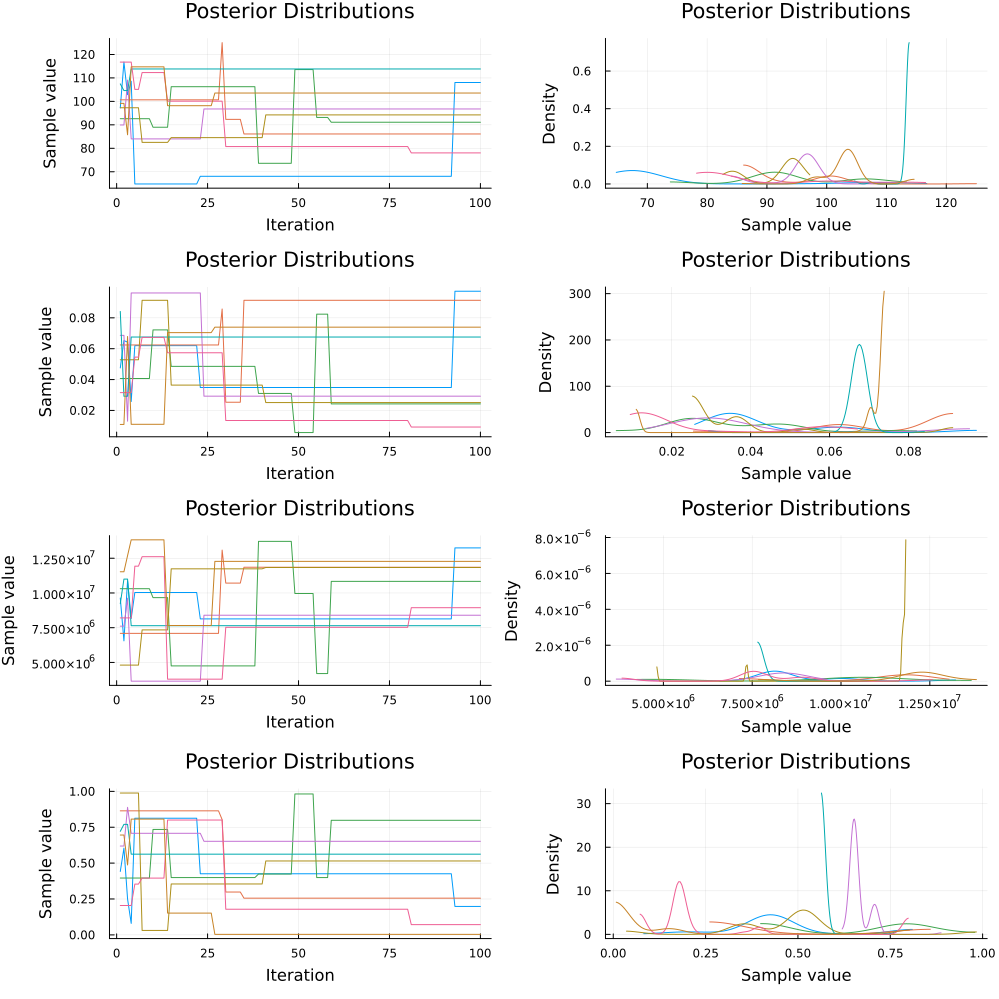

In [195]:
plot(chain[:,1:4,:], title="Posterior Distributions", legend=false)

In [ ]:
plot(samples, title="Posterior Distributions", legend=false)

In [130]:
# using Pkg
#using MCMCChains
using MCMCChains
using AdaptiveMCMC



@model function infinite_chain(y, Nx=N, Ny=N)
    # Priors
    # Cs = 1 #mm
    # Cs = Cs * 1e7 #convert to Angstroms
    B ~ truncated(Normal(0.1, 1), 0, 2)
    Cs ~ truncated(Normal(1e7, 3e6), 0, Inf)
    θ ~ Exponential(20)
    φ ~ Normal(0, 0.1)
    ϕ ~ filldist(truncated(Normal(π/2, π),0,3*π/2), Ny, Nx)


    # Likelihood
    
    y ~ arraydist(Poisson.(vec(
        abs2.(
            reshape(first_term(Cs, ϕ),Ny,Nx,1,1 ) .+ 
            reshape(second_term(Cs, θ, φ), 1, 1, Ny, Nx)) 
            .+ B)))
end
λ_model_alloc = Array{Float64,4}(undef, N, N, N, N)
function log_likelihood(x::AbstractVector{T}, 
    data::typeof(measurement_noised)=measurement_noised, 
    Nx=N, Ny=N, λ_model::typeof(λ_model_alloc)=λ_model_alloc)::T where {T<:AbstractFloat}

    ϕ = reshape(x[1:Nx*Ny], Ny, Nx)
    φ = x[end-3]      
    θ = abs(x[end-2])
    Cs = abs(x[end-1])
    B = abs(x[end])


    # lp_B  = logpdf(truncated(Normal(0.1, 1), 0, 2), B)
    # lp_Cs = logpdf(truncated(Normal(1e7, 3e6), 0, Inf), Cs)
    # lp_θ  = logpdf(Exponential(20), θ)
    # lp_φ  = logpdf(Normal(0, 0.1), φ)
    # if lp_B == 0.0 || lp_Cs == 0.0 || lp_θ == 0.0 || lp_φ == 0.0
    #     return -Inf
    # end

    
    
    
    λ_model .= abs2.(
        reshape(first_term(Cs, ϕ),Ny,Nx,1,1 ) .+ 
                reshape(second_term(Cs, θ, φ), 1, 1, Ny, Nx)) 
                .+ B
    
    return sum(@. data*log(λ_model) - λ_model) #+ lp_B + lp_Cs + lp_θ + lp_φ
end








# x0[1:end-2] = vec(phase_real[1:Ty, 1:Tx])
# x0[end] = 0.1/ π/2
# x0[end-1] = 1
# x0[end] = 0.125
# x0[end-1] = π/8
# x0 = avg_copy
# x0[end-3] = 5
# hetroscedastic = fill(1.0, length(x0))
# hetroscedastic[end] = 0.05
# hetroscedastic[end-1] = 0.8
# rand_func(rng, x::Vector{Float64}) = hetroscedastic.*randn!(rng, x)




function parallel_rwm()
    Ny, Nx = N, N
    x0 = zeros(Ny*Nx + 4)
    x0[end] = 0.1
    x0[end-1] = 1e7
    x0[end-2] = 0.1
    x0[end-3] = 0.0
    n = 5000
    thining = 1
    burn_in = n÷2
    interations = (n-burn_in)÷thining + 1
    n_chains = 10

    rwm_chains_parallel = Array{Float64, 3}(undef, interations, length(x0), n_chains)
    Threads.@threads for i in 1:n_chains
        rwm_chains_parallel[:, :, i] = Transpose(adaptive_rwm(x0, log_likelihood, n; 
                                                thin=thining, L=2, b=burn_in,
                                                algorithm=:asm, 
                                                swaps =:nonrev)[1])
    end
    return rwm_chains_parallel
end
rwm_chains_parallel = parallel_rwm();



In [32]:
@benchmark log_likelihood(x0)

BenchmarkTools.Trial: 30 samples with 1 evaluation per sample.
 Range (min … max):  144.712 ms … 260.482 ms  ┊ GC (min … max): 0.00% … 4.36%
 Time  (median):     158.559 ms               ┊ GC (median):    4.65%
 Time  (mean ± σ):   170.401 ms ±  32.442 ms  ┊ GC (mean ± σ):  4.36% ± 0.91%

         █                                                       
  ▃▁▁▃▁▄▅█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  145 ms           Histogram: frequency by time          260 ms <

 Memory estimate: 257.09 MiB, allocs estimate: 110.

In [114]:
@benchmark log_likelihood(x0)

BenchmarkTools.Trial: 41 samples with 1 evaluation per sample.
 Range (min … max):  119.629 ms … 128.045 ms  ┊ GC (min … max): 0.00% … 2.62%
 Time  (median):     124.617 ms               ┊ GC (median):    2.64%
 Time  (mean ± σ):   124.698 ms ±   1.194 ms  ┊ GC (mean ± σ):  2.58% ± 0.42%

                                   ▆▄▁█  ▃                       
  ▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▄████▄▆█▁▁▄▁▄▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▆ ▁
  120 ms           Histogram: frequency by time          128 ms <

 Memory estimate: 128.60 MiB, allocs estimate: 65.

In [115]:
ϕ = reshape(x0[1:Nx*Ny], Ny, Nx)
φ = x0[end-3]      
θ = abs(x0[end-2])
Cs = abs(x0[end-1])
# @btime first_term(Cs, ϕ);

0.0

In [131]:
samples = Chains(rwm_chains_parallel)

Chains MCMC chain (2501×4100×10 Array{Float64, 3}):

Iterations        = 1:1:2501
Number of chains  = 10
Samples per chain = 2501
parameters        = param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8, param_9, param_10, param_11, param_12, param_13, param_14, param_15, param_16, param_17, param_18, param_19, param_20, param_21, param_22, param_23, param_24, param_25, param_26, param_27, param_28, param_29, param_30, param_31, param_32, param_33, param_34, param_35, param_36, param_37, param_38, param_39, param_40, param_41, param_42, param_43, param_44, param_45, param_46, param_47, param_48, param_49, param_50, param_51, param_52, param_53, param_54, param_55, param_56, param_57, param_58, param_59, param_60, param_61, param_62, param_63, param_64, param_65, param_66, param_67, param_68, param_69, param_70, param_71, param_72, param_73, param_74, param_75, param_76, param_77, param_78, param_79, param_80, param_81, param_82, param_83, param_84, param_85, param_86,

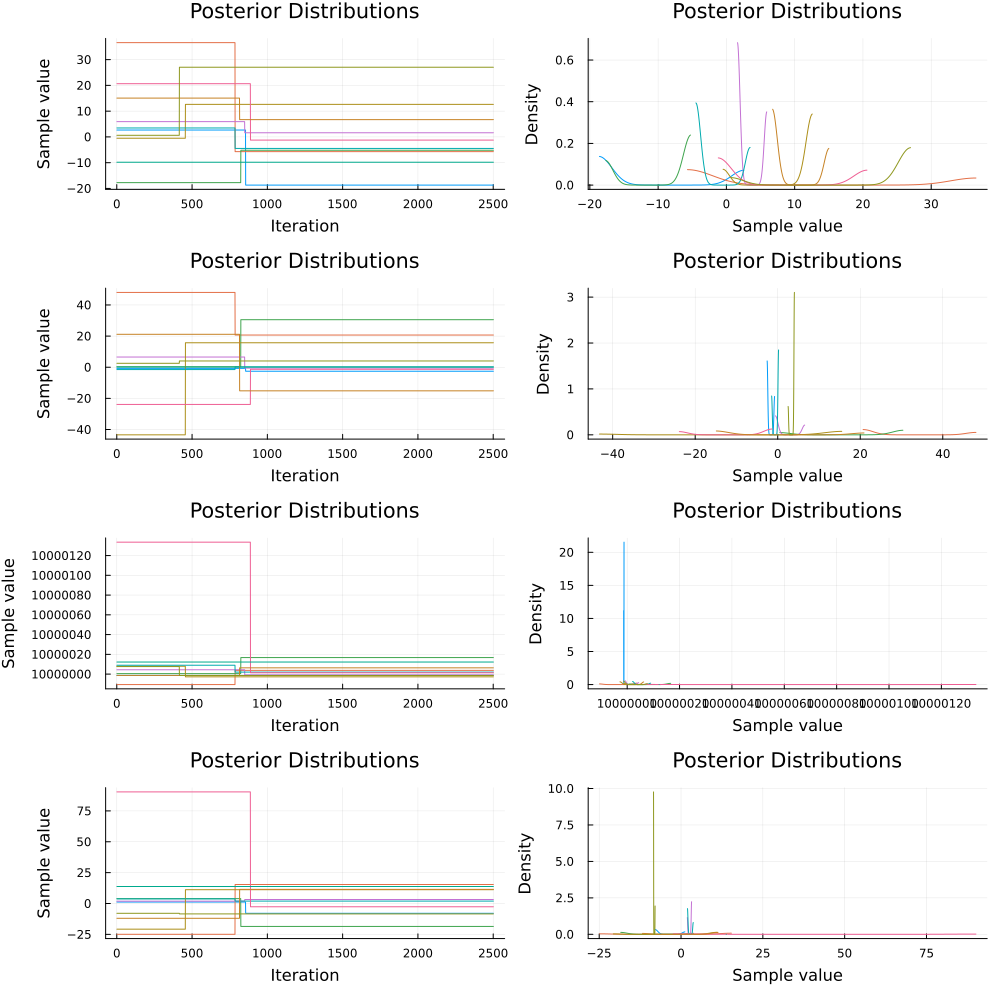

In [133]:
plot(samples[:,end-3:end,:], labels=["B", "Cs", "θ", "φ"], title="Posterior Distributions", xlabel="Parameter Value", ylabel="Density")

In [264]:
summaries, quantiles = describe(chain)

2-element Vector{ChainDataFrame}:
 Summary Statistics (4100 x 8)
 Quantiles (4100 x 6)

In [265]:
summaries

Summary Statistics
  parameters           mean            std          mcse   ess_bulk   ess_tail ⋯
      Symbol        Float64        Float64       Float64    Float64    Float64 ⋯

           B         0.9981         0.7809        0.2973     8.0165        NaN ⋯
          Cs   9514745.5465   1051120.3272   305475.6024    10.1673        NaN ⋯
           θ        11.3622        12.4415        4.5153     7.3269        NaN ⋯
           φ         0.0818         0.0962        0.0337     8.0166        NaN ⋯
     ϕ[1, 1]         1.6775         1.1855        0.4078     9.1330        NaN ⋯
     ϕ[2, 1]         3.0878         1.2114        0.4553     7.0066        NaN ⋯
     ϕ[3, 1]         1.3447         0.9193        0.2643    11.3407        NaN ⋯
     ϕ[4, 1]         3.0756         0.5803        0.2171     7.4518        NaN ⋯
     ϕ[5, 1]         2.5624         1.2103        0.4089    11.3407        NaN ⋯
     ϕ[6, 1]         1.8730         1.1573        0.4254     7.3229        NaN ⋯
     ϕ[7

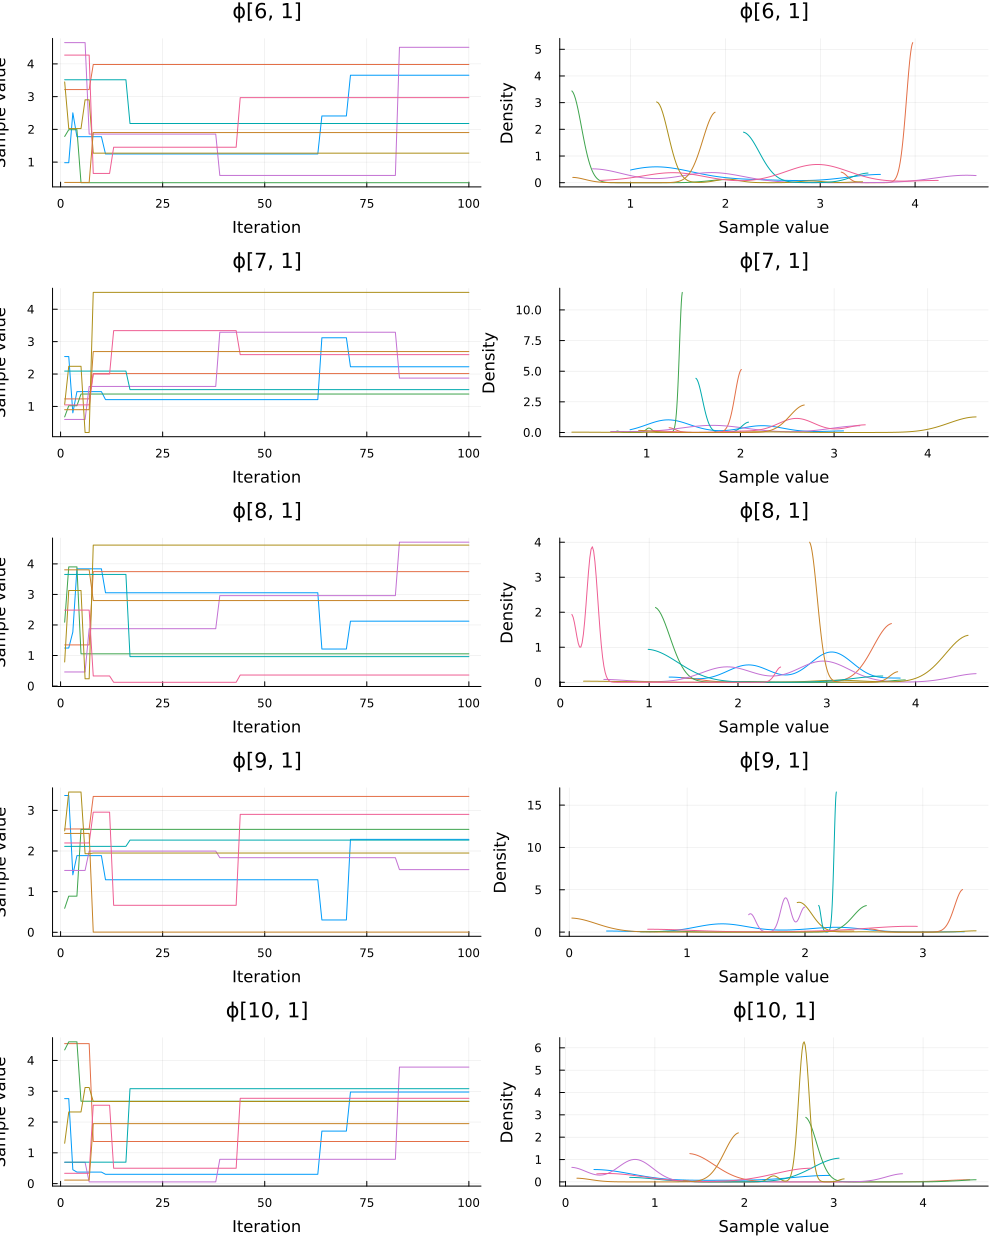

In [272]:
plot(chain[:,10:14,:])

In [267]:
# Suppose you want the first element of φ for each sample:
plot(chain[:, ["B", "Cs", "θ", "φ"], :], seriestype=:trace, title="Trace Plots")# plot(chain, seriestype=:density, title="Density Plots")


AssertionError: AssertionError: all((ptype->begin
            #= /home/nicolas/.julia/packages/MCMCChains/RIFg4/src/plot.jl:207 =#
            ptype ∈ supportedplots
        end), ptypes)